In [2]:
from utils.utils import transform_ghg_dataset

import pandas as pd
from os import path
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# Constants
DATA_DIR = "./dataset/ghg/2050-historical-and-projected-sectoral-emissions-data-November_2023-for-publishing-v01.xlsx"
SAVE_DIR = "model/timegan_synth_dataset.pkl"

FEATURES = ["Gross - Central"]

In [4]:
df = transform_ghg_dataset(DATA_DIR)
df = df[FEATURES]
df = df.iloc[:32]
cols = list(df.columns)

print(df.shape)
df.head(5)

(32, 1)


,Gross - Central
0,67903.078125
1,68890.218750
2,70027.718750
3,69923.015625
4,71165.445312


In [5]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=cols)

print(df_scaled.shape)
df_scaled.head(5)

(32, 1)


,Gross - Central
0,0.000000
1,0.056978
2,0.122635
3,0.116591
4,0.188305


In [6]:
# Define model parameters
gan_args = ModelParameters(batch_size=32,
                           lr=5e-4,
                           noise_dim=32,
                           layers_dim=128,
                           latent_dim=24,
                           gamma=1)

train_args = TrainParameters(epochs=15000,
                             sequence_length=16,
                             number_sequences=df_scaled.shape[1])

In [7]:
if path.exists(SAVE_DIR):
    synth = TimeSeriesSynthesizer.load(SAVE_DIR)
else:
    synth = TimeSeriesSynthesizer(modelname='timegan', model_parameters=gan_args)
    synth.fit(df_scaled, train_args, num_cols=cols)
    synth.save(SAVE_DIR)

In [8]:
df_scaled_transformed = np.array(real_data_loading(df, 16))
synth_data = np.array(synth.sample(n_samples=16))

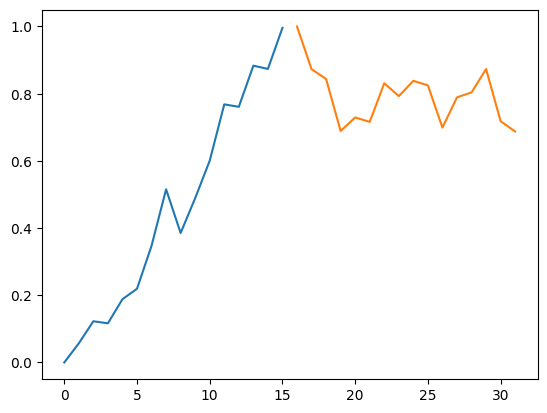

In [9]:
plt.plot(df_scaled[0:16])
plt.plot(df_scaled[16:32])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(16, 16, 1) (16, 16, 1)


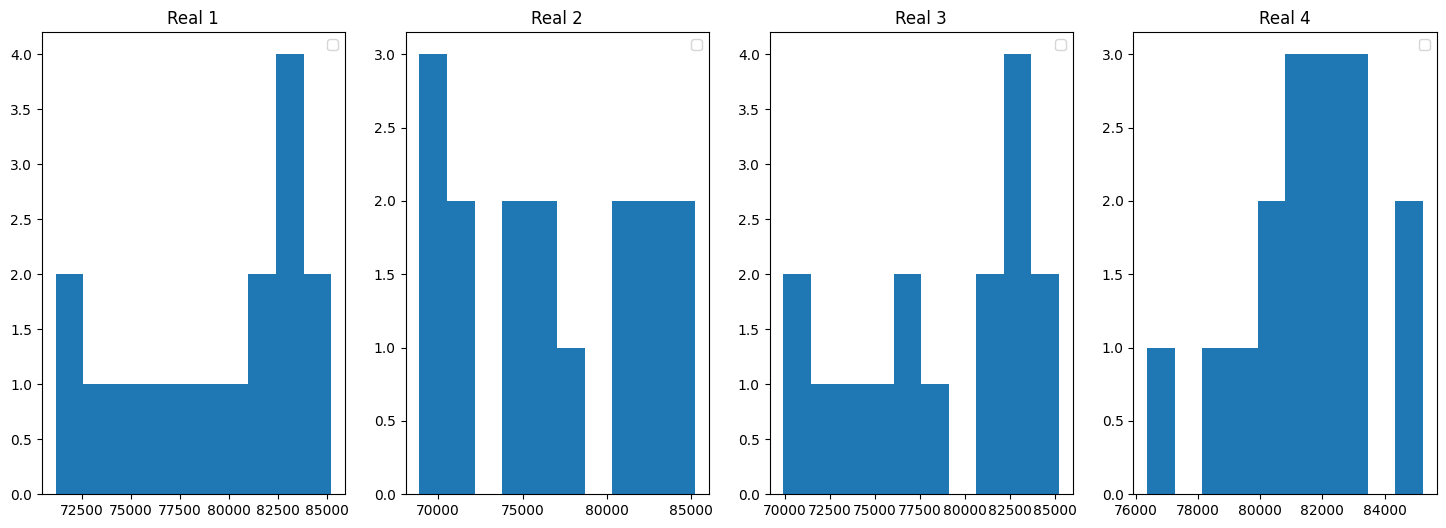

In [26]:
print(np.array(synth_data).shape, np.array(df_scaled_transformed).shape)

itf_df = scaler.inverse_transform(df_scaled_transformed.flatten().reshape(16, 16))
itf_synth = scaler.inverse_transform(synth_data.flatten().reshape(16, 16))

a_list = [8,1,7,11]

fig = plt.figure(1, figsize=(18,6))

for i, obs in enumerate(a_list, 1):
    ax = plt.subplot(1, len(a_list), i)
    ax.set_title(f"Real {i}")
    # ax.plot(itf_df[obs][:16], label="real")
    # ax.plot(itf_synth[obs][:16], label="synthetic")
    ax.hist(itf_df[obs][:16])
    # ax.hist(itf_synth[obs][:16])
    ax.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(16, 16, 1) (16, 16, 1)


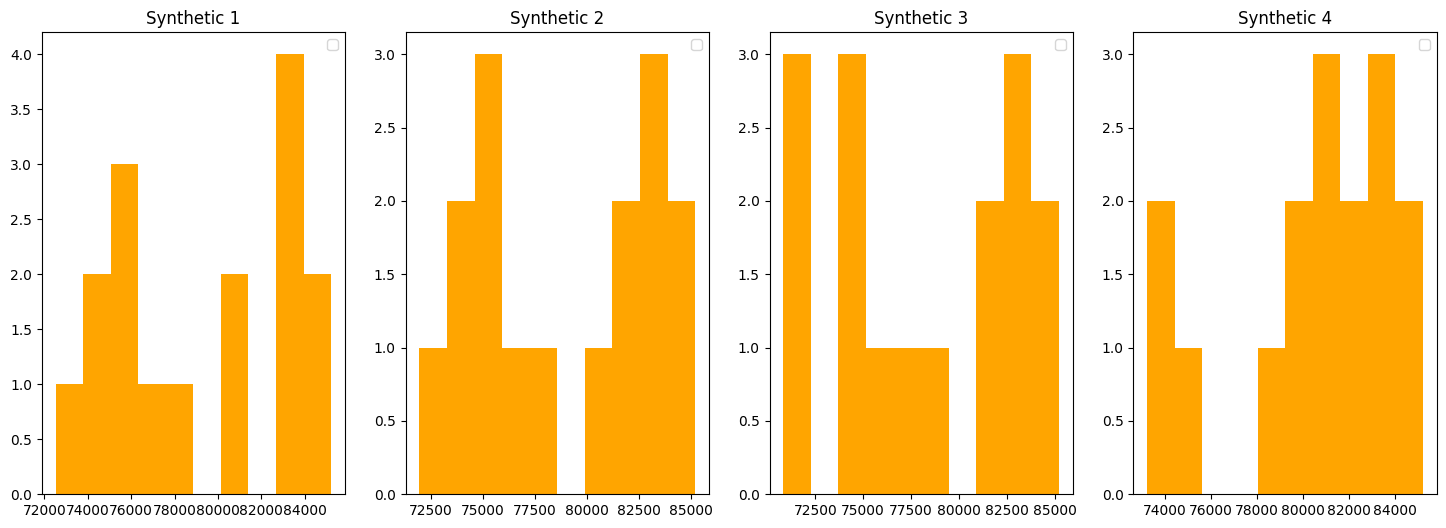

In [28]:
print(np.array(synth_data).shape, np.array(df_scaled_transformed).shape)

itf_df = scaler.inverse_transform(df_scaled_transformed.flatten().reshape(16, 16))
itf_synth = scaler.inverse_transform(synth_data.flatten().reshape(16, 16))

a_list = [8,1,7,11]

fig = plt.figure(1, figsize=(18,6))

for i, obs in enumerate(a_list, 1):
    ax = plt.subplot(1, len(a_list), i)
    ax.set_title(f"Synthetic {i}")
    # ax.plot(itf_df[obs][:16], label="real")
    # ax.plot(itf_synth[obs][:16], label="synthetic")
    # ax.hist(itf_df[obs][:16])
    ax.hist(itf_synth[obs][:16], color="orange")
    ax.legend()

plt.show()

In [11]:
# Evaluation using RMSE
rms = mean_squared_error(itf_df, itf_synth, squared=False)
mape = mean_absolute_percentage_error(itf_df, itf_synth)
# print("The Average differences between Real data and Synth data is %d" % (rms))
print("RMSE: %d\nMAPE: %.2f" % (rms, mape*100))

RMSE: 3697
MAPE: 3.76


In [12]:
# Export to csv
# SAVE_PATH = "./dataset/synth/synth_data.csv"

# synth_df = pd.DataFrame(itf_synth)
# synth_df.to_csv(SAVE_PATH, index=False)